This script contains some improvement from train.ipynb by default:
* much few layers, heads, and embedding dimension to reduce the model size
* dataloader v2 which uses a custom tokenizer (again to reduce model size)
* no positional embeddings (to reduce model complexity)
* weight tying (to reduce model size)


We implemented a few things here first and not before:
* validation losses
* increased the model size to be just below 30M parameters
* reduced the amount of data trained with to keep the training (wall) time consistent
* made graph more informative

This script contains a couple improvements from train2.ipynb:
* gradient accumulation is enabled
* the dataloader chunks from the start of an example up to the max_length or the endoftext token

This contains some changes from train3.ipynb:
* an accuracy metric has been implemented
* one cycle learning rate schedule is being used
* weight tying is disabled

This contains some improvements from train4.ipynb: just that the attention module used uses pytorchs implementation for sdpa. This also uses a text generation function to display the capabilities of the trained model.

In [1]:
import socket
socket.gethostname()

'DESKTOP-ISTII7E'

In [2]:
GPT_CONFIG_30M = {
    "vocab_size": 30002,
    "context_length": 256,
    "emb_dim": 512,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": True,
    "no_pos_emb": True
}

In [3]:
GPT_CONFIG_60M = {
    "vocab_size": 30002,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 8,
    "n_layers": 8,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": True
}

In [4]:
import socket
hostname = socket.gethostname().lower()
if "laptop" in hostname:
    GPT_CONFIG = GPT_CONFIG_30M
else:
    GPT_CONFIG = GPT_CONFIG_60M

In [5]:
import torch.nn as nn
import torch

torch.set_float32_matmul_precision('medium')

In [6]:
trainer_config = {
    "dataset_scale": 5,
    "batch_size": 32 if "laptop" in hostname else 32,
    "epochs": 1,
    "train_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-train.txt",
    "valid_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-valid.txt",
    "num_workers": 11 if "laptop" in hostname else 23,
    "max_lr": 1e-3
}
trainer_config["grad_batches"] = 256 // trainer_config["batch_size"]

In [7]:
from torch.optim.lr_scheduler import OneCycleLR
from components.data import create_dataloader_v3
import lightning as L

class LitGPTModel(L.LightningModule):
    def __init__(self, GPTModel, trainer_config, gpt_config):
        super().__init__()
        self.gpt_config = gpt_config
        self.trainer_config = trainer_config
        self.model = GPTModel

        self.train_accuracy = []
        self.val_accuracy = []
        self.train_losses = []
        self.val_losses = []
        self.val_steps = []
        self.learning_rates = []
        self.batch_step = 0

    def _accuracy(self, output, expected):
        total_matching = (torch.argmax(output, dim=-1) == expected).sum().item()
        total_numel = expected.numel()
        return total_matching / total_numel

    def training_step(self, batch, batch_idx):
        self.batch_step += 1
        x, y = batch
        logits = self.model(x)

        accuracy = self._accuracy(logits, y)
        self.log("accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.train_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.train_losses.append(loss.item())

        current_lr = self.optimizers().param_groups[0]["lr"]
        self.learning_rates.append(current_lr)

        return loss

    def validation_step(self, batch, batch_idx):
        self.val_steps.append(self.batch_step)
        x, y = batch

        logits = self.model(x)

        accuracy = self._accuracy(logits, y)
        self.log("val_accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.val_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.val_losses.append(loss.item())
        
        return loss

    def loss(self, output, expected):
        loss = nn.functional.cross_entropy(
            output.flatten(0, 1), expected.flatten()
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.trainer_config["max_lr"], weight_decay=0.1
        )

        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.trainer_config["max_lr"],
            total_steps=self.trainer.estimated_stepping_batches,
        )
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "monitor": "loss"
        }

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler_config
        }

    def setup(self, stage):
        # todo, build model in this function
        with open(self.trainer_config["train_file_loc"], encoding="utf-8") as f:
            self.train_text = f.read()

            text_len = len(self.train_text)
            dataset_scale = self.trainer_config["dataset_scale"]
            self.train_text = self.train_text[:text_len // dataset_scale]

        with open(self.trainer_config["valid_file_loc"], encoding="utf-8") as f:
            self.valid_text = f.read()

            # ensure validation set is not too long
            train_len = len(self.train_text)
            self.valid_text = self.valid_text[:train_len // 10]
        
    def _create_dataloader(self, text, train_loader):
        return create_dataloader_v3(
            text,
            batch_size=self.trainer_config["batch_size"],
            max_length=self.gpt_config["context_length"],
            stride=self.gpt_config["context_length"],
            drop_last=train_loader,
            shuffle=train_loader,
            num_workers=self.trainer_config["num_workers"]
        )

    def train_dataloader(self):
        # consider setting self.train_text = None if memory consumption is an issue
        train_loader = self._create_dataloader(
            self.train_text,
            train_loader=True
        )
        return train_loader

    def val_dataloader(self):
        return self._create_dataloader(
            self.valid_text,
            train_loader=False
        )


In [8]:
from components.gptmodel import GPTModel_v2
model = GPTModel_v2(GPT_CONFIG)
litmodel = LitGPTModel(
    model,
    trainer_config,
    GPT_CONFIG
)

In [9]:
%%time

trainer = L.Trainer(
    max_epochs=trainer_config["epochs"],
    enable_progress_bar=True,
    accumulate_grad_batches=trainer_config["grad_batches"]
)
trainer.fit(model=litmodel)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-04-01 13:02:17.172224: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 13:02:17.190252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743537737.205237    3162 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743537737.209254    3162 cuda_blas.cc:1407] Unable to regis

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████| 16992/16992 [34:33<00:00,  8.19it/s, v_num=39, accuracy_step=0.842, loss_step=0.620]
Validation: |                                                                                                                                                        | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 864/864 [00:36<00:00, 23.71it/s]
Epoch 0: 100%|█| 16992/16992 [35:10<00:00,  8.05it/s, v_num=39, accuracy_step=0.842, loss_step=0.620, val_accuracy_step=0.880, val_loss_step=0.452, val_accuracy_epoch=0.849, val_loss_epoc

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|█| 16992/16992 [35:11<00:00,  8.05it/s, v_num=39, accuracy_step=0.842, loss_step=0.620, val_accuracy_step=0.880, val_loss_step=0.452, val_accuracy_epoch=0.849, val_loss_epoc
CPU times: user 34min 45s, sys: 40.3 s, total: 35min 25s
Wall time: 35min 23s


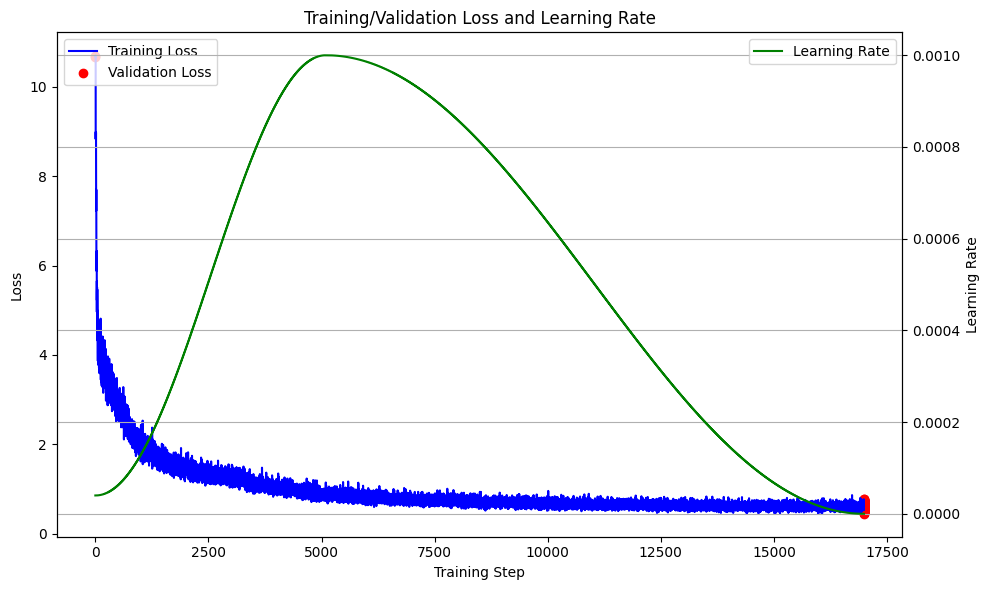

In [10]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(litmodel.train_losses, label="Training Loss", color="blue")
ax1.scatter(litmodel.val_steps, litmodel.val_losses, label="Validation Loss", color="red")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(litmodel.learning_rates, label="Learning Rate", color="green")
ax2.set_ylabel("Learning Rate")
ax2.legend(loc="upper right")

plt.title("Training/Validation Loss and Learning Rate")
plt.tight_layout()
plt.grid(True)
plt.show()

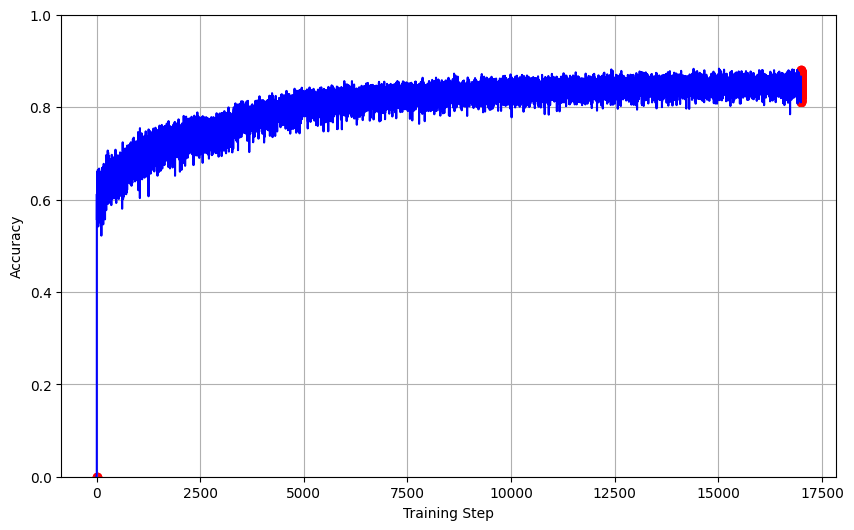

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(litmodel.train_accuracy, color="blue")
plt.scatter(litmodel.val_steps, litmodel.val_accuracy, color="red")
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [12]:
from tokenizers import Tokenizer

In [13]:
tokenizer = Tokenizer.from_file("./TinyStories_tokenizer.json")

In [14]:
from tokenizers import decoders
tokenizer.decoder = decoders.WordPiece()

In [15]:
from components.generatetext import generate_text

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
litmodel.model.to(device)

GPTModel_v2(
  (tok_emb): Embedding(30002, 512)
  (pos_emb): Embedding(512, 512)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock_v2(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=512, out_features=512, bias=False)
        (W_key): Linear(in_features=512, out_features=512, bias=False)
        (W_value): Linear(in_features=512, out_features=512, bias=False)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock_v2(
     

In [17]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is still. And so much, they did a good, even more, they all. The moral more. They were happy, they did, they all, even more, even when they did a big and again, they did not even better, and then, they all the big, and then again and then, they did not even better and they both learned, even let ' t. From that even more and again, and they did not let again. And even let ' t again.
CPU times: user 418 ms, sys: 76.5 ms, total: 494 ms
Wall time: 534 ms


In [18]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is still. They were very sad and then they both happy, and then they could both, even if.
CPU times: user 65.8 ms, sys: 9.62 ms, total: 75.4 ms
Wall time: 78.1 ms


In [19]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is still. They both, they did not let ' s all day, and the end of their friend, and then, and then they both happy again and then, and they all their friend, and again, and then. They both happy again. From that even more, and then, even more, they both learned that even and they both, and again, they both and again and they both and again, they still again, and again.
CPU times: user 269 ms, sys: 28.7 ms, total: 298 ms
Wall time: 314 ms


In [20]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is happy. And so much, and they all day. They did it again and then they did. And then, and the big, and the big, they did a little more, and then, and again, and then they did they did they all more and again and again. And even better and then they both did not even more. And they both learned. And even more. From then, and again. And they did not again, and then even let again and then even more. From even more. From even more and learned, then even let the end, and then even let again, and learned, then again, even let ' re still again and learned that even even even more. And then even more, and learned that they still again.
CPU times: user 4